In [1]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf



In [2]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0DGV09/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0DGV09/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0DGV09/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

In [4]:
for item in train_data:
    print(item)
    break

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

In [13]:
tokenizer = info.features['text'].encoder
print(tokenizer.subwords[:10])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br']


In [14]:
len(tokenizer.subwords)

7928

In [15]:
string = "TensorFlow, from basics to mastery"

tokenized_string = tokenizer.encode(string) # encoder에 있는 subwords 기준으로 encode
# 초기 subwords는 문장을 n-gram으로 쪼갠뒤 쪼갠 n-gram들을 빈도수 기반으로 만듦(fasttext)
# 당연히 n-gram으로 쪼개서 초기 subwords를 만드는 건 시간이 너무 오래걸림 그래서 누군가 만든 subwords data를 이용하는게 일반적

print(tokenized_string)

original_string = tokenizer.decode(tokenized_string)
print(original_string)

[6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
TensorFlow, from basics to mastery


In [16]:
for token in tokenized_string:
    print("{} -> {}".format(token, tokenizer.decode([token]))) # list로 받음

# TensorFlow를 모르지만 Ten을 알고 sor를 알고 Fl도 알고 ow도 알고있으니 이 들을 합치면 TensorFlow라는 의미와 비슷해지지 않을까 라는 것

6307 -> Ten
2327 -> sor
4043 -> Fl
2120 -> ow
2 -> , 
48 -> from 
4249 -> basi
4429 -> cs 
7 -> to 
2652 -> master
8050 -> y


In [17]:
len(train_data)

25000

In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE) # BUFFER_SIZE 만큼 data를 shuffle하여 가지고옴
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset)) # padded_batch : 준 크기만큼 padded되어서 날아옴

test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))


In [31]:
test_dataset

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [29]:
train_dataset

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [19]:
tf.compat.v1.data.get_output_shapes(train_dataset)

(TensorShape([None, None]), TensorShape([None]))

In [20]:
type(train_dataset) # PaddedBatchDataset

tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset

In [33]:
#tokenizer.vocab_size = 8185

embedding_dim = 64
max_length = 120
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')

])

# Embedding(7, 2, input_length=5)
# 7은 단어의 개수. 즉, 단어 집합(vocabulary)의 크기이다.
# 2는 임베딩한 후의 벡터의 크기이다.
# 5는 각 입력 시퀀스의 길이. 즉, input_length이다.

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 528,065
Trainable params: 528,065
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

history = model.fit(train_dataset, validation_data=test_dataset, epochs=NUM_EPOCHS)

Epoch 1/10
391/391 [==============================] - 11s 26ms/step - loss: 0.6299 - accuracy: 0.6475 - val_loss: 0.4820 - val_accuracy: 0.8140
Epoch 2/10
391/391 [==============================] - 11s 26ms/step - loss: 0.3620 - accuracy: 0.8616 - val_loss: 0.3329 - val_accuracy: 0.8716
Epoch 3/10
391/391 [==============================] - 10s 25ms/step - loss: 0.2679 - accuracy: 0.8993 - val_loss: 0.3702 - val_accuracy: 0.8366
Epoch 4/10
391/391 [==============================] - 10s 25ms/step - loss: 0.2271 - accuracy: 0.9164 - val_loss: 0.3132 - val_accuracy: 0.8778
Epoch 5/10
391/391 [==============================] - 11s 26ms/step - loss: 0.1986 - accuracy: 0.9278 - val_loss: 0.3062 - val_accuracy: 0.8821
Epoch 6/10
391/391 [==============================] - 10s 24ms/step - loss: 0.1733 - accuracy: 0.9387 - val_loss: 0.3203 - val_accuracy: 0.8767
Epoch 7/10
391/391 [==============================] - 10s 26ms/step - loss: 0.1639 - accuracy: 0.9406 - val_loss: 0.3427 - val_accuracy:

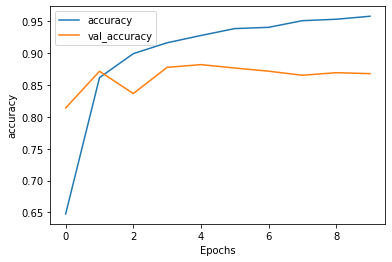

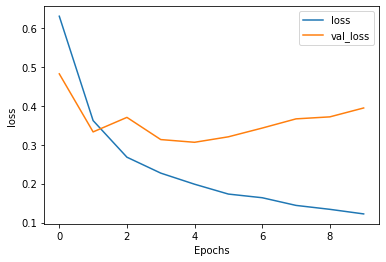

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# **LSTM** 설정

In [37]:
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
                             tf.keras.layers.LSTM(64),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')

])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 153,809
Trainable params: 153,809
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

history = model.fit(train_dataset, validation_data=test_dataset, epochs=NUM_EPOCHS)

Epoch 1/10
391/391 [==============================] - 34s 73ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 2/10
391/391 [==============================] - 30s 76ms/step - loss: 0.6932 - accuracy: 0.5047 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/10
391/391 [==============================] - 30s 74ms/step - loss: 0.6927 - accuracy: 0.4982 - val_loss: 0.6929 - val_accuracy: 0.5022
Epoch 4/10
391/391 [==============================] - 33s 82ms/step - loss: 0.6911 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5024
Epoch 5/10
391/391 [==============================] - 30s 75ms/step - loss: 0.6902 - accuracy: 0.5046 - val_loss: 0.6927 - val_accuracy: 0.5034
Epoch 6/10
391/391 [==============================] - 28s 72ms/step - loss: 0.6892 - accuracy: 0.5033 - val_loss: 0.6926 - val_accuracy: 0.5009
Epoch 7/10
391/391 [==============================] - 32s 82ms/step - loss: 0.6872 - accuracy: 0.5018 - val_loss: 0.6937 - val_accuracy:

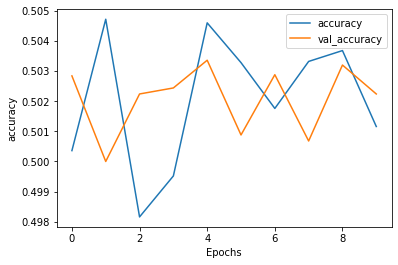

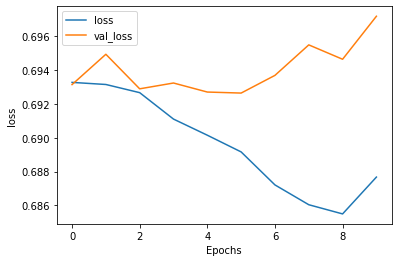

In [40]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# **BI-directional LSTM**






In [44]:
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')

])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 176,593
Trainable params: 176,593
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

history = model.fit(train_dataset, validation_data=test_dataset, epochs=NUM_EPOCHS)

Epoch 1/10
391/391 [==============================] - 54s 131ms/step - loss: 0.5692 - accuracy: 0.6907 - val_loss: 0.4605 - val_accuracy: 0.8001
Epoch 2/10
391/391 [==============================] - 57s 145ms/step - loss: 0.3694 - accuracy: 0.8491 - val_loss: 0.4173 - val_accuracy: 0.8261
Epoch 3/10
391/391 [==============================] - 50s 126ms/step - loss: 0.3043 - accuracy: 0.8817 - val_loss: 0.4199 - val_accuracy: 0.8218
Epoch 4/10
391/391 [==============================] - 53s 134ms/step - loss: 0.2722 - accuracy: 0.8974 - val_loss: 0.4451 - val_accuracy: 0.8431
Epoch 5/10
391/391 [==============================] - 55s 139ms/step - loss: 0.2296 - accuracy: 0.9166 - val_loss: 0.4143 - val_accuracy: 0.8319
Epoch 6/10
391/391 [==============================] - 51s 129ms/step - loss: 0.2118 - accuracy: 0.9230 - val_loss: 0.4544 - val_accuracy: 0.8228
Epoch 7/10
391/391 [==============================] - 51s 128ms/step - loss: 0.2475 - accuracy: 0.9079 - val_loss: 0.4658 - val_ac

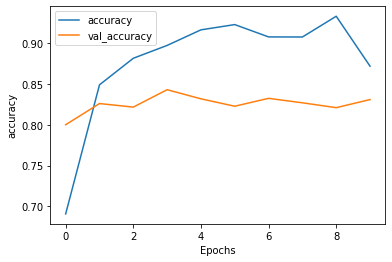

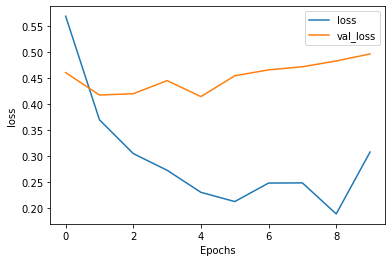

In [47]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# embedding_dim = 16
# model = tf.keras.Sequential([
#                              tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
#                              tf.keras.layers.BIdirectional(tf.keras.layers.LSTM(128), return_sequences=True), # LSTM층을 쌓을때마다 다음 LSTM층으로 return_sequences=True로 둬야함
#                              tf.keras.layers.BIdirectional(tf.keras.layers.LSTM(64), return_sequences=True),
#                              tf.keras.layers.BIdirectional(tf.keras.layers.LSTM(32)),
#                              tf.keras.layers.Dense(32, activation='PReLU'),
#                              tf.keras.layers.Dense(32, activation='relu'),
#                              tf.keras.layers.Dense(1, activation='sigmoid')

# ])

# **BI-directional GRU**

In [51]:
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
                             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)), # stacking
                             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                             tf.keras.layers.Dense(32, activation='PReLU'),
                             tf.keras.layers.Dense(1, activation='sigmoid')

])

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

history = model.fit(train_dataset, validation_data=test_dataset, epochs=NUM_EPOCHS)

Epoch 1/10
391/391 [==============================] - 139s 226ms/step - loss: 0.6115 - accuracy: 0.6534 - val_loss: 0.6492 - val_accuracy: 0.6490
Epoch 2/10
391/391 [==============================] - 89s 225ms/step - loss: 0.4616 - accuracy: 0.7769 - val_loss: 0.3725 - val_accuracy: 0.8352
Epoch 3/10
391/391 [==============================] - 89s 226ms/step - loss: 0.2912 - accuracy: 0.8822 - val_loss: 0.3577 - val_accuracy: 0.8467
Epoch 4/10
391/391 [==============================] - 89s 226ms/step - loss: 0.2236 - accuracy: 0.9128 - val_loss: 0.3696 - val_accuracy: 0.8528
Epoch 5/10
391/391 [==============================] - 89s 227ms/step - loss: 0.1815 - accuracy: 0.9335 - val_loss: 0.3593 - val_accuracy: 0.8549
Epoch 6/10
391/391 [==============================] - 89s 227ms/step - loss: 0.1547 - accuracy: 0.9444 - val_loss: 0.3939 - val_accuracy: 0.8572
Epoch 7/10
391/391 [==============================] - 90s 228ms/step - loss: 0.1386 - accuracy: 0.9515 - val_loss: 0.4126 - val_a

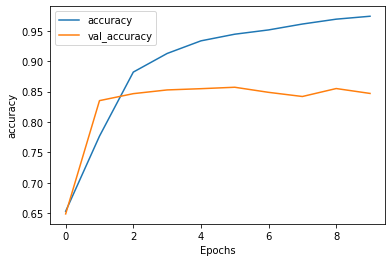

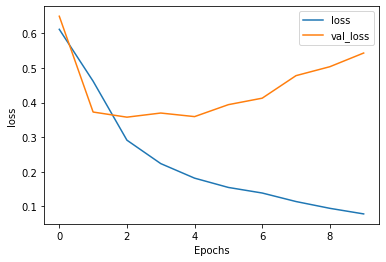

In [53]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')